In [55]:
import base64
import os
import cv2
import joblib
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from enum import Enum
import torch
import clip
from PIL import Image
from typing import List
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# from joblib.externals.loky import get_reusable_executor
# import time
dataset_path = 'VOCdevkit/VOC2012/JPEGImages'


In [56]:
class EncodingType(Enum):
    KMeans = 1
    CLIP = 2

class Coder:
    def __init__(self, encoding_type: EncodingType):
        self.encoding_type = encoding_type
        if self.encoding_type == EncodingType.KMeans:
            self.kmeans = joblib.load('kmeans_1000_512.joblib')
            self.sift = cv2.SIFT.create()
        elif encoding_type == EncodingType.CLIP:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        
    def encode(self, img_path) -> np.ndarray:
        if self.encoding_type == EncodingType.KMeans:
            return self._img_path_to_bovw(img_path)
        elif self.encoding_type == EncodingType.CLIP:
            return self._img_path_to_clip(img_path)
        
    def _img_path_to_bovw(self, img_path: str) -> np.ndarray:
        # Load image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Get SIFT descriptors
        _, descriptors = self.sift.detectAndCompute(image, None)
        if descriptors is None:
            default_hist = np.zeros(self.kmeans.n_clusters)
            default_hist[:] = 1 / self.kmeans.n_clusters
            return default_hist
        predictions = self.kmeans.predict(descriptors)

        # Compute histogram
        histogram = np.bincount(predictions, minlength=self.kmeans.n_clusters)
        histogram = histogram / np.sum(histogram)
        return histogram
    
    def _img_path_to_clip(self, img_path: str) -> np.ndarray:
        image = self.preprocess(Image.open(img_path)).unsqueeze(0).to(self.device)
        return self.model.encode_image(image).cpu().detach().numpy().squeeze().astype(np.float64)

In [57]:
@np.vectorize
def encode_array(a: np.ndarray) -> bytes:
    return base64.b64encode(a).decode('utf8')


def decode_array(s: str) -> np.array:
    b = base64.b64decode(s.encode('utf8'))
    return np.frombuffer(b, dtype=np.float64)


def save_as_csv(image_paths: List, encoded_images: List, csv_path: str) -> None:
    df = pd.DataFrame({
        'id': range(len(encoded_images)),
        'path': image_paths,
        'vector': encoded_images
    })
    df['vector'] = encode_array(df['vector'])
    df.to_csv(csv_path, index=False)
    
    
def get_from_csv(csv_path: str) -> pd.DataFrame:
    dataframe = pd.read_csv(csv_path, index_col=0)
    dataframe['vector'] = dataframe['vector'].map(decode_array)
    return dataframe


def load_rbg(path: str) -> np.ndarray:
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

## SIFT + KMeans + Histograms

In [68]:
coder_kmeans = Coder(encoding_type=EncodingType.KMeans)

c:\Content\mmcs\masters_degree\semester_1\cv\lab13-14\CV1314\.venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [69]:
N_IMGS = 1000
image_paths = [os.path.join(dataset_path, img_name) for img_name in os.listdir(dataset_path)[:N_IMGS]]
encoded_images = joblib.Parallel(n_jobs=-1, prefer='threads')(
    joblib.delayed(coder_kmeans.encode)(img_path) for img_path in image_paths
)
save_as_csv(image_paths, encoded_images, 'db_kmeans.csv')

## CLIP

In [75]:
coder_clip = Coder(encoding_type=EncodingType.CLIP)

In [76]:
N_IMGS = 1000
image_paths = [os.path.join(dataset_path, img_name) for img_name in os.listdir(dataset_path)[:N_IMGS]]
encoded_images = []
for img_path in tqdm(image_paths):
    encoded_images.append(coder_clip.encode(img_path))
save_as_csv(image_paths, encoded_images, 'db_clip.csv')

100%|██████████| 1000/1000 [00:14<00:00, 67.66it/s]


## Similar Images

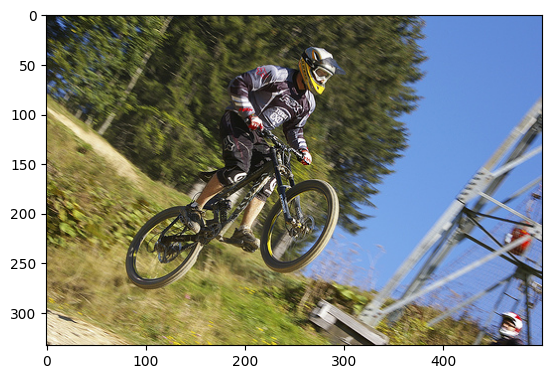

In [62]:
path = 'VOCdevkit/VOC2012/JPEGImages/2012_004308.jpg'
plt.imshow(load_rbg(path))

### KMeans

In [70]:
img = coder_kmeans.encode(path)

In [71]:
df_kmeans = get_from_csv('db_kmeans.csv')
df_kmeans.head()

path  \
id                                                 
0   VOCdevkit/VOC2012/JPEGImages\2007_000027.jpg   
1   VOCdevkit/VOC2012/JPEGImages\2007_000032.jpg   
2   VOCdevkit/VOC2012/JPEGImages\2007_000033.jpg   
3   VOCdevkit/VOC2012/JPEGImages\2007_000039.jpg   
4   VOCdevkit/VOC2012/JPEGImages\2007_000042.jpg   

                                               vector  
id                                                     
0   [0.0, 0.0031774852473899226, 0.001361779391738...  
1   [0.0026455026455026454, 0.0, 0.0, 0.0, 0.00793...  
2   [0.0, 0.010526315789473684, 0.0, 0.0, 0.008421...  
3   [0.0, 0.0, 0.0, 0.0, 0.007957559681697613, 0.0...  
4   [0.0, 0.0017857142857142857, 0.0, 0.0, 0.00357...

In [72]:
neighbors_kmeans = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
neighbors_kmeans.fit(np.vstack(df_kmeans['vector'].values), df_kmeans.index.values)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [73]:
_, indices_kmeans = neighbors_kmeans.kneighbors([img], n_neighbors=10)
indices_kmeans

array([[ 50, 558, 293,  80, 474, 107, 363, 166, 391, 334]], dtype=int64)

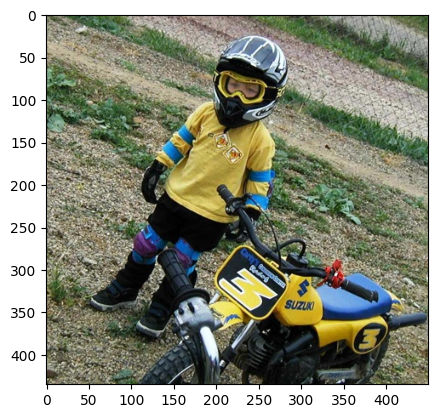

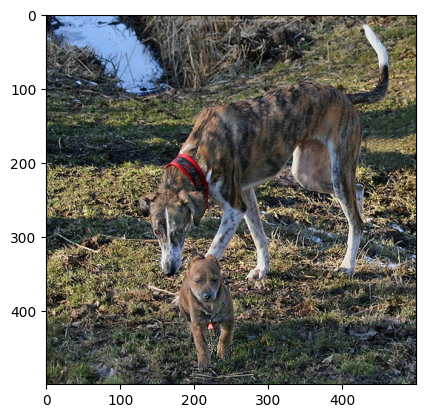

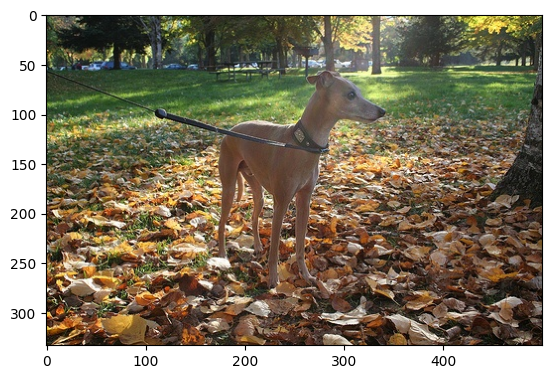

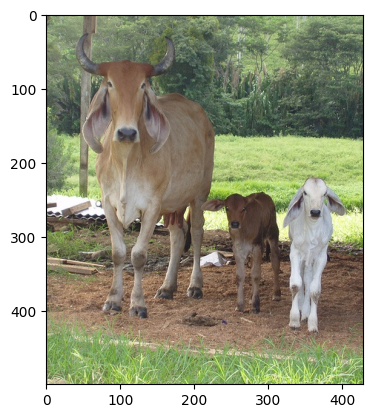

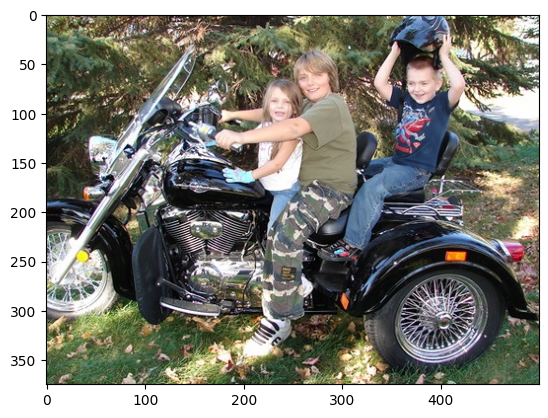

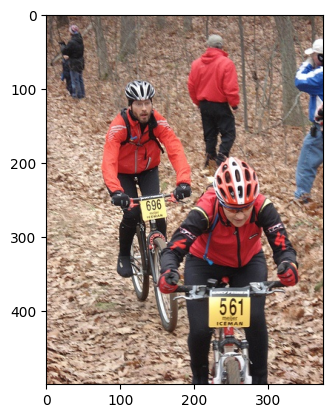

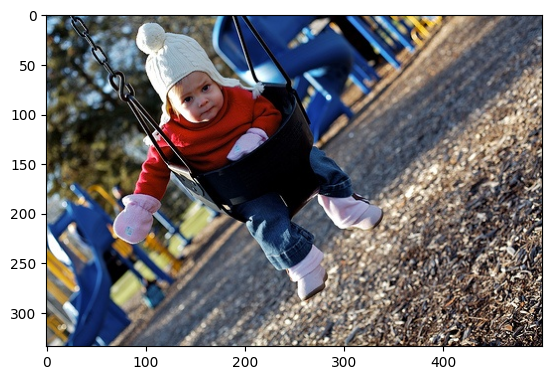

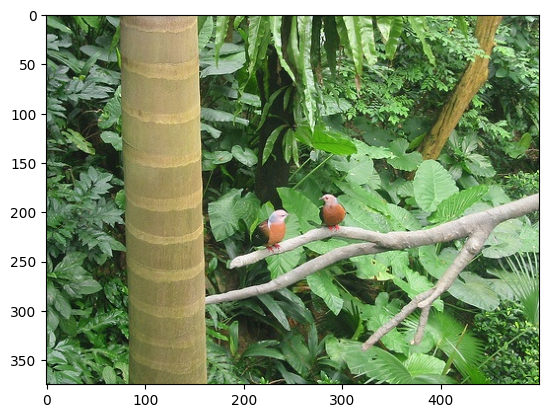

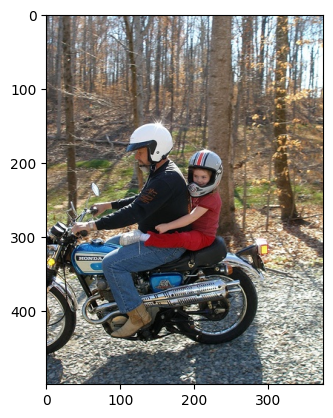

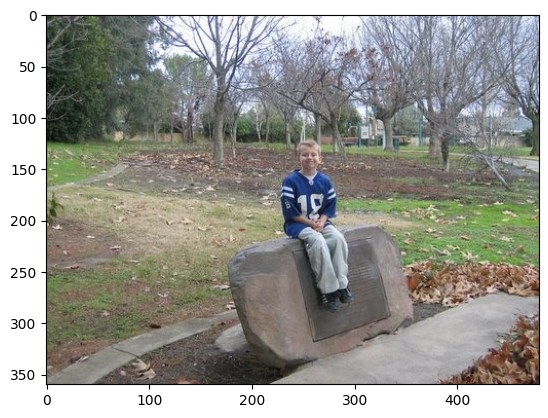

In [74]:
for idx in indices_kmeans.flat:
    plt.imshow(load_rbg(df_kmeans.loc[idx]['path']))
    plt.show()

### CLIP

In [77]:
img = coder_clip.encode(path)

In [78]:
df_clip = get_from_csv('db_clip.csv')
df_clip.head()

path  \
id                                                 
0   VOCdevkit/VOC2012/JPEGImages\2007_000027.jpg   
1   VOCdevkit/VOC2012/JPEGImages\2007_000032.jpg   
2   VOCdevkit/VOC2012/JPEGImages\2007_000033.jpg   
3   VOCdevkit/VOC2012/JPEGImages\2007_000039.jpg   
4   VOCdevkit/VOC2012/JPEGImages\2007_000042.jpg   

                                               vector  
id                                                     
0   [-0.701171875, 0.390869140625, -0.058898925781...  
1   [-0.1346435546875, 0.01137542724609375, -0.022...  
2   [0.116455078125, 0.2401123046875, -0.239135742...  
3   [-0.049041748046875, 0.77978515625, 0.40283203...  
4   [0.196533203125, 0.2086181640625, -0.348388671...

In [79]:
neighbors_clip = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
neighbors_clip.fit(np.vstack(df_clip['vector'].values), df_clip.index.values)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [80]:
_, indices_clip = neighbors_clip.kneighbors([img], n_neighbors=10)
indices_clip

array([[114, 468, 529, 400,  81, 580,  10, 107, 682, 545]], dtype=int64)

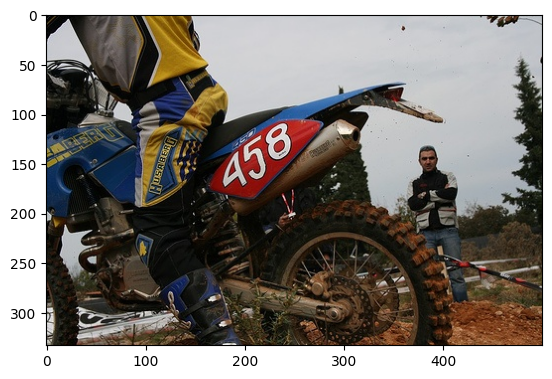

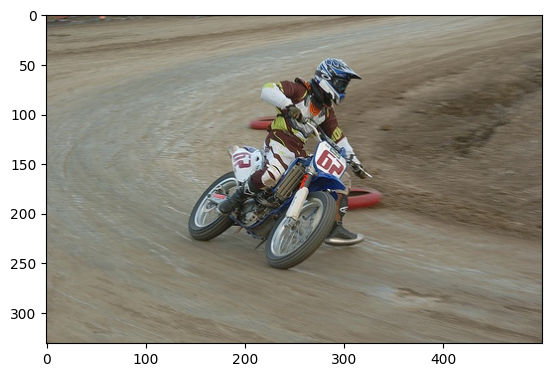

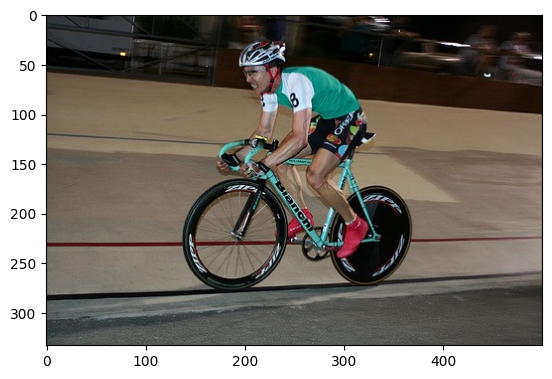

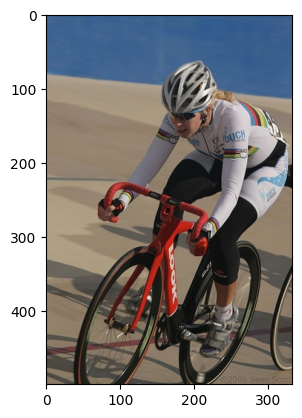

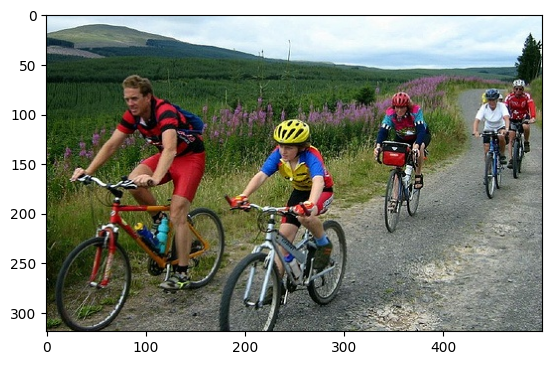

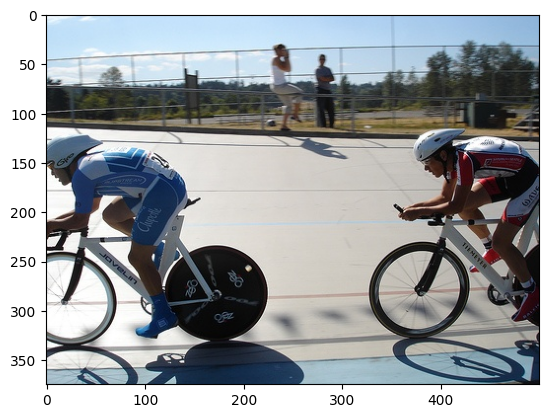

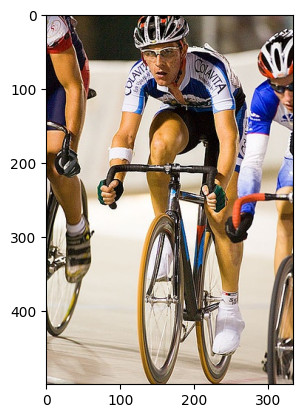

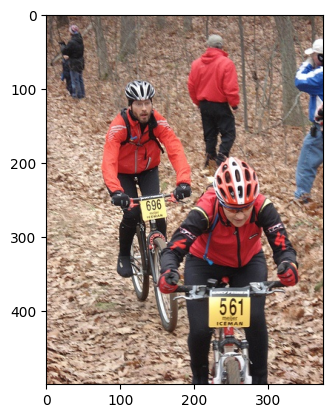

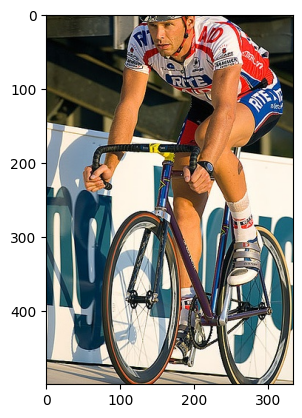

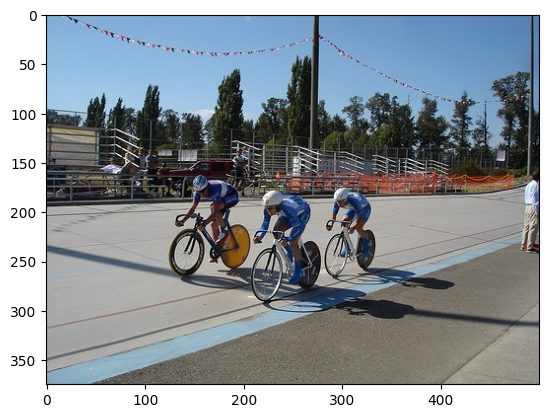

In [81]:
for idx in indices_clip.flat:
    plt.imshow(load_rbg(df_clip.loc[idx]['path']))
    plt.show()